<a href="https://colab.research.google.com/github/billbch/TP1/blob/main/data_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pascal-voc-writer
#!pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pascal_voc_writer import Writer
import xml.etree.ElementTree as ET

import random

import cv2
# making a function to load the image
def load_img(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import albumentations as A

import os

In [ ]:
img_id = 0

In [ ]:
# folder path
dir_path = r'/content/'

# list to store files
jpg_files = []
xml_files = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)) and ('xml' not in path):
        jpg_files.append(path)

for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)) and ('xml' in path):
        xml_files.append(path)

jpg_files.sort()
xml_files.sort()
print(jpg_files)
print(xml_files)

['IMG_7245.JPG']
['IMG_7245.xml']


In [ ]:
# parse xml file
tree = ET.parse(f"/content/{xml_files[img_id]}") 
root = tree.getroot() # get root object

In [ ]:
height = int(root.find("size")[0].text)
width = int(root.find("size")[1].text)
channels = int(root.find("size")[2].text)

In [ ]:
bbox_class = []
bboxes = []

for member in root.findall('object'):
    class_name = member[0].text # class name
        
    # bbox coordinates
    xmin = int(member[4][0].text)
    ymin = int(member[4][1].text)
    xmax = int(member[4][2].text)
    ymax = int(member[4][3].text)
    # store data in list
    bbox_class.append(class_name)
    bboxes.append([xmin, ymin, xmax, ymax])

print(bbox_class)
print(bboxes)

['Hueco_grave', 'Hueco_grave']
[[131, 454, 259, 523], [365, 352, 513, 425]]


In [ ]:
category_name_to_id = {'Hueco_leve': 1, 'Hueco_medio': 2, 'Hueco_grave': 3, 'Grieta': 4}
category_id_to_name = {1: 'Hueco_leve', 2: 'Hueco_medio', 3:'Hueco_grave', 4:'Grieta'}

category_ids = [category_name_to_id[class_lbl] for class_lbl in bbox_class]
category_ids

[3, 3]

In [ ]:
def get_image_with_bb(image, bbs):
    # Plotting bboxes in the image
    image_with_bb = image.copy()
    for bb in bbs:
        cv2.rectangle(image_with_bb, tuple(bb[:2]), tuple(bb[2:]), (255, 0, 0), 2)
    return image_with_bb

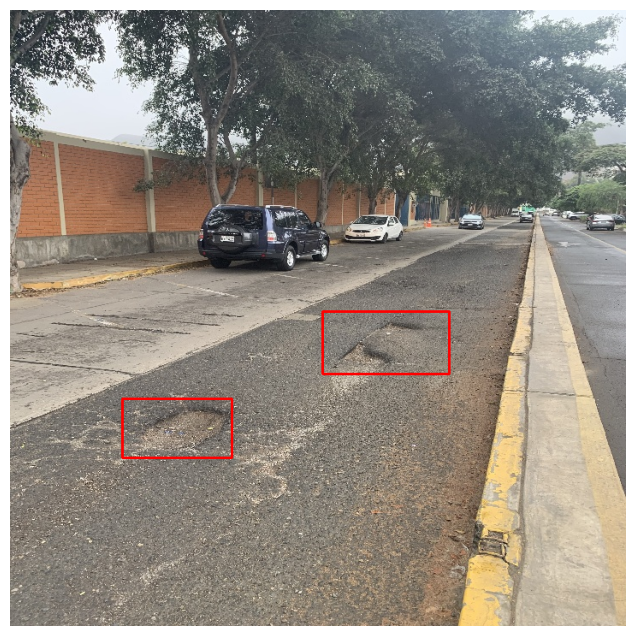

In [ ]:
image = load_img(f"/content/{jpg_files[img_id]}")
image_with_bb = get_image_with_bb(image, bboxes)
plt.figure(figsize=(14, 8))
plt.imshow(image_with_bb)
plt.axis('off')
plt.show()

In [ ]:
transformFlip = A.Compose(
    [A.HorizontalFlip(p=1),
     #A.Resize(512, 512),
    ],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)

transformBright = A.Compose(
    [A.HorizontalFlip(p=0.5),
     A.RandomBrightness(p=1),
     #A.Resize(512, 512),
    ],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)

transformCont = A.Compose(
    [A.HorizontalFlip(p=0.5),
     A.RandomContrast(limit = [0.4, 0.5],p = 1)
     #A.Resize(512, 512),
    ],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [ ]:
transformedFlip = transformFlip(image=image, bboxes=bboxes,
                                category_ids=category_ids) # give image, bboxes and class_labels to transform

transformedBright = transformBright(image=image, bboxes=bboxes,
                                category_ids=category_ids) # give image, bboxes and class_labels to transform

transformedCont = transformCont(image=image, bboxes=bboxes,
                                category_ids=category_ids) # give image, bboxes and class_labels to transform

In [ ]:
def get_bbox(bboxes, col, category_ids, category_conv, color='white', bbox_format='pascal_voc'):
    
    for i in range(len(bboxes)):
        # Create a Rectangle patch
        colors = ['','red', 'white', 'blue', 'green']
        lbl = category_conv[category_ids[i]]
        if bbox_format == 'pascal_voc':
            rect = patches.Rectangle(
                (bboxes[i][0], bboxes[i][1]),
                bboxes[i][2] - bboxes[i][0], 
                bboxes[i][3] - bboxes[i][1], 
                linewidth=2, 
                edgecolor=colors[category_ids[i]], 
                facecolor='none',
                label=lbl)
        else:
            rect = patches.Rectangle(
                (bboxes[i][0], bboxes[i][1]),
                bboxes[i][2], 
                bboxes[i][3], 
                linewidth=2, 
                edgecolor=color, 
                facecolor='none')

        # Add the patch to the Axes
        col.add_patch(rect)

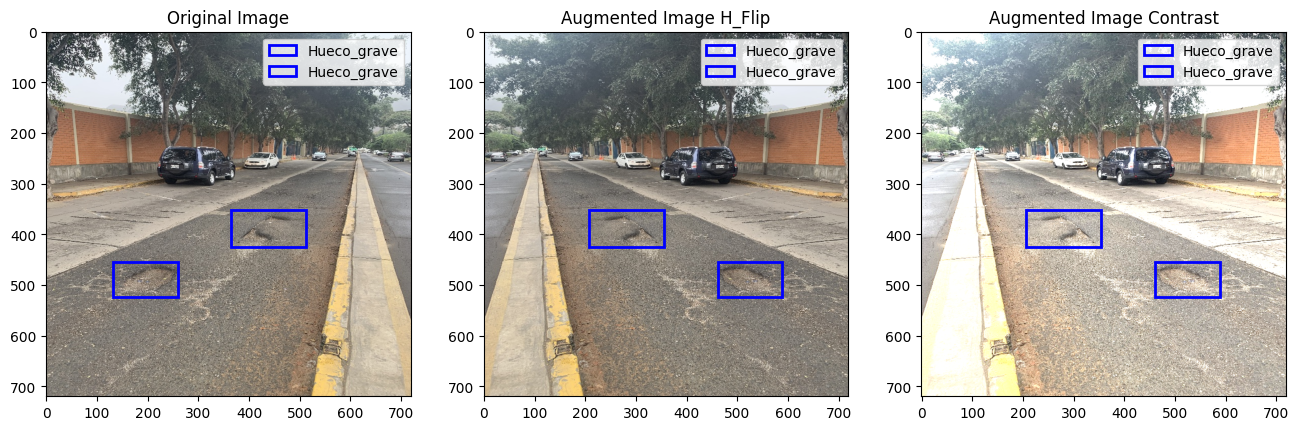

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))
get_bbox(bboxes, ax[0], category_ids, category_id_to_name, color='red', bbox_format='pascal_voc')
ax[0].title.set_text('Original Image')
ax[0].legend(loc='upper right')
ax[0].imshow(image)

get_bbox(transformedFlip['bboxes'] , ax[1], category_ids, category_id_to_name, color='red', bbox_format='pascal_voc')
ax[1].title.set_text('Augmented Image H_Flip')
ax[1].imshow(transformedFlip['image'])
ax[1].legend(loc='upper right')

get_bbox(transformedCont['bboxes'] , ax[2], category_ids, category_id_to_name, color='red', bbox_format='pascal_voc')
ax[2].title.set_text('Augmented Image Contrast')
ax[2].imshow(transformedCont['image'])
ax[2].legend(loc='upper right')

plt.show()

# XML GEN

In [ ]:
transformedFlip['image'].shape

(720, 720, 3)

In [ ]:
bboxes

[[14, 564, 322, 703], [482, 404, 692, 506], [205, 379, 465, 494]]

In [ ]:
transformedFlip['bboxes']

[(398.0, 564.0, 706.0, 703.0),
 (27.99999999999998, 404.0, 238.00000000000003, 505.99999999999994),
 (254.99999999999997, 379.0, 515.0, 494.0)]

In [ ]:
from pascal_voc_writer import Writer

# create pascal voc writer (image_path, width, height)
writer = Writer(f'/my-project-name/{jpg_files[img_id]}_2.jpg', 720, 720)

i_box = 0
for box in transformedFlip['bboxes']:
    # add objects (class, xmin, ymin, xmax, ymax)
    writer.addObject(bbox_class[i_box], int(box[0]), int(box[1]), int(box[2]), int(box[3]))
    i_box += 1

# write to file
writer.save(f'{jpg_files[img_id]}_2.xml')
cv2.imwrite(f'{jpg_files[img_id]}_2.jpg', cv2.cvtColor(transformedFlip['image'], cv2.COLOR_RGB2BGR))

True